## Instruction 

- 데이터 로드 : 라이브러리를 로드 및 4개의 CSV 파일에서의 데이터 활용
- 텍스트 토큰화 : 토큰화를 위해 바이트 쌍 인코딩(BPE)을 사용해 강력한 텍스트 표현을 생성
- TF-IDF 벡터화 : 토큰화된 텍스트에 TF-IDF 벡터화를 구현하여 중요한 특징 확인
- 모델 훈련 : 머신 러닝 모델(다항식 나이브 베이즈, SGD, LightGBM, CatBoost)의 앙상블 구성
- 제출물 생성: 모델 훈련을 통해 얻은 예측을 제출 파일('submission.csv')로 출력

## Import Libraries

In [42]:
import sys
import gc

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

## Load Dataset

- train_essays : 원본 훈련 데이터
- test : 원본 테스트 데이터
- sub : 원본 제출 데이터

In [43]:
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
sub = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

In [44]:
# 원본 데이터 크기 확인
train_essays.shape, test.shape, sub.shape

((1378, 4), (3, 3), (3, 2))

In [45]:
# 훈련 데이터 확인
train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [46]:
# 훈련 데이터 값 확인
train_essays['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

### 훈련 데이터 EDA 확인

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

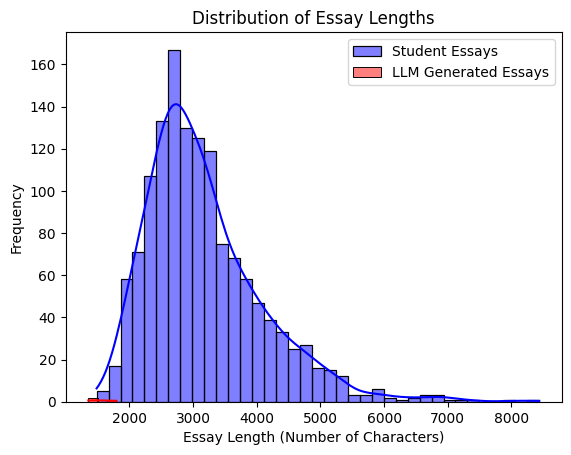

In [47]:
# 각 에세이의 길이를 계산하고 새 열을 만듦
train_essays['essay_length'] = train_essays['text'].apply(len)

# 학생 에세이(train_essays)이의 길이 분포
sns.histplot(train_essays[train_essays['generated'] == 0]['essay_length'], color="blue", label='Student Essays', kde=True)

# LLM에서 생성된 에세이의 길이 분포
sns.histplot(train_essays[train_essays['generated'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Tokenizer

- train : 'train_v2_drcat_02.csv' CSV 파일, 해당 파일은 TF-IDF 벡터화를 위한 추가 학습 데이터 세트

In [48]:
train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv", sep=',')

In [49]:
# 추가 학습 데이터 확인
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


### 중복 행 제거

- 'text'열을 기준으로 중복 행 제거
- 인덱스를 재설정

In [50]:
train = train.drop_duplicates(subset=['text'])
train.reset_index(drop=True, inplace=True)

### 매개변수 구성

- LOWERCASE : 불리안 변수로 대소문자 구분 변수
- VOCAB_SIZE : 어휘의 크기를 나타내는 변수, 모델이 해당 크기만큼의 고유 토큰이 포함된 어휘로 작업

In [51]:
LOWERCASE = False
VOCAB_SIZE = 30522

### BPE 작업

#### 1. 토큰화 객체 생성

In [52]:
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

#### 2.정규화 및 Pre-Toknizer

In [53]:
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

#### 3.BPE Trainer 구성

In [54]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

#### 4.Tokenizer 훈련

In [55]:
dataset = Dataset.from_pandas(test[['text']])

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [56]:
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

In [57]:
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

#### 5.PreTrainedTokenizerFast 생성

In [58]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]")

#### 6.테스트 및 훈련 데이터 토큰화

In [59]:
tokenized_texts_test = []
for text in tqdm(test['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

  0%|          | 0/3 [00:00<?, ?it/s]

In [60]:
tokenized_texts_train = []
for text in tqdm(train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/44868 [00:00<?, ?it/s]

In [61]:
tokenized_texts_test[1]

['ĠBbb', 'Ġccc', 'Ġddd', '.']

## TF-IDF 벡터화

- scikit-learn의 TfidVectorizer을 사용한 TF-IDF 벡터화

### 더미 함수 정의

- 텍스트 입력을 받아 동일한 텍스트를 반환
- TF-IDF Toknizer의 자리 표시자로 사용

In [62]:
def dummy(text):
    return text

### TF-IDF 벡터 구성 및 Test data Fitting

In [63]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5), 
                             lowercase=False, 
                             sublinear_tf=True, 
                             analyzer = 'word',
                             tokenizer = dummy,
                             preprocessor = dummy,
                             token_pattern = None,
                             strip_accents='unicode')

In [64]:
vectorizer.fit(tokenized_texts_test)

TfidfVectorizer(lowercase=False, ngram_range=(3, 5),
                preprocessor=<function dummy at 0x7c7b05446200>,
                strip_accents='unicode', sublinear_tf=True, token_pattern=None,
                tokenizer=<function dummy at 0x7c7b05446200>)

### 어휘 얻기

- test data에서 학습한 어휘 확인

In [65]:
vocab = vectorizer.vocabulary_

In [66]:
print(vocab)

{'ĠAaa Ġbbb Ġccc': 0, 'Ġbbb Ġccc .': 6, 'ĠAaa Ġbbb Ġccc .': 1, 'ĠBbb Ġccc Ġddd': 2, 'Ġccc Ġddd .': 7, 'ĠBbb Ġccc Ġddd .': 3, 'ĠCCC Ġddd Ġeee': 4, 'Ġddd Ġeee .': 8, 'ĠCCC Ġddd Ġeee .': 5}


### TF-IDF 벡터 재구성 및 훈련데이터 변환

- test data에서 학습한 어휘로 TF-IDF vectorizer 재구성
- 재구성한 vectorizer 사용하여 train data의 토큰화된 텍스트 TF-IDF feature로 변환

In [67]:
vectorizer = TfidfVectorizer(ngram_range=(3, 5), 
                             lowercase=False, 
                             sublinear_tf=True, 
                             vocabulary=vocab,
                             analyzer = 'word',
                             tokenizer = dummy,
                             preprocessor = dummy,
                             token_pattern = None, 
                             strip_accents='unicode')

In [68]:
tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

### Vectorizer 삭제 및 메모리 정리

- gc.collect를 사용하여 메모리 확보

In [69]:
del vectorizer
gc.collect()

128

In [70]:
y_train = train['label'].values

## Model

- Ensemble :  다항식 나이브 베이즈, 확률적 경사 하강법, LightGBM, Catboost 활용
- 각 모델이 확률 추정치를 제공해주는 soft 투표 전략을 사용하여 Ensemble Model 생성
- 해당 파라미터값들은 Competition의 Code 참고
- Ensemble 가중치를 변경하며 확인

In [71]:
def model():
    from catboost import CatBoostClassifier
    clf = MultinomialNB(alpha=0.02)
#     clf2 = MultinomialNB(alpha=0.01)
    sgd_model = SGDClassifier(max_iter=5000, tol=1e-4, loss="modified_huber") 
    p6 = {
        'n_iter': 1500,
        'verbose': -1,
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05073909898961407,
        'colsample_bytree': 0.726023996436955,
        'colsample_bynode': 0.5803681307354022,
        'lambda_l1': 8.562963348932286,
        'lambda_l2': 4.893256185259296,
        'min_data_in_leaf': 115,
        'max_depth': 23,
        'max_bin': 898
    }
    lgb = LGBMClassifier(**p6)
    cat = CatBoostClassifier(
        iterations=1000,
        verbose=0,
        l2_leaf_reg=6.6591278779517808,
        learning_rate=0.005689066836106983,
        allow_const_label=True,
        loss_function = 'CrossEntropy',
        random_seed=1234
    )
    weights = [0.07,0.3,0.3,0.3]
 
    ensemble = VotingClassifier(
        estimators=[
            ('mnb',clf),
            ('sgd', sgd_model),
            ('lgb',lgb), 
            ('cat', cat)
        ],
        weights=weights, voting='soft', n_jobs=-1
    )
    return ensemble

In [72]:
# def get_model():
#     from catboost import CatBoostClassifier
#     clf = MultinomialNB(alpha=0.01)
# #     clf2 = MultinomialNB(alpha=0.01)
#     sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
#     p6 = {
#         'n_iter': 3000,
#         'verbose': -1,
#         'objective': 'binary',
#         'metric': 'auc',
#         'learning_rate': 0.05073909898961407,
#         'colsample_bytree': 0.726023996436955,
#         'colsample_bynode': 0.5803681307354022,
#         'lambda_l1': 8.562963348932286,
#         'lambda_l2': 4.893256185259296,
#         'min_data_in_leaf': 115,
#         'max_depth': 23,
#         'max_bin': 898
#     }
#     lgb = LGBMClassifier(**p6)
#     cat = CatBoostClassifier(
#         iterations=2000,
#         verbose=0,
#         l2_leaf_reg=6.6591278779517808,
#         learning_rate=0.005689066836106983/2,
#         allow_const_label=True,
#         loss_function = 'CrossEntropy',
#         random_seed=1234
#     )
#     weights = [0.07,0.41,0.41,0.41]
 
#     ensemble = VotingClassifier(
#         estimators=[
#             ('mnb',clf),
#             ('sgd', sgd_model),
#             ('lgb',lgb), 
#             ('cat', cat)
#         ],
#         weights=weights, voting='soft', n_jobs=-1
#     )
#     return ensemble

In [73]:
model = model()
print(model)

VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=0.02)),
                             ('sgd',
                              SGDClassifier(loss='modified_huber',
                                            max_iter=5000, tol=0.0001)),
                             ('lgb',
                              LGBMClassifier(colsample_bynode=0.5803681307354022,
                                             colsample_bytree=0.726023996436955,
                                             lambda_l1=8.562963348932286,
                                             lambda_l2=4.893256185259296,
                                             learning_rate=0.05073909898961407,
                                             max_bin=898, max_depth=23,
                                             metric='auc', min_data_in_leaf=115,
                                             n_iter=1500, objective='binary',
                                             verbose=-1)),
                             ('cat',
   

## Training

- test data의 크기가 5보다 작은지 확인하여 참이면 if문
    - 매우 작은 데이터 세트 처리할때 사용
- TF-IDF로 변환된 테스트 데이터(tf_test)에서 학습된 앙상블 모델을 사용하여 최종 예측 생성


In [74]:
if len(test.text.values) <= 5:
    # if not, just sample submission
    sub.to_csv('submission.csv', index=False)
else:
    model.fit(tf_train, y_train)

    gc.collect()

    final_preds = model.predict_proba(tf_test)[:,1]
    sub['generated'] = final_preds
    sub.to_csv('submission.csv', index=False)
    sub

In [75]:
sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4
